In [74]:
####################read dataset#########################
import os
import random
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

image_folder = "data/img"
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".jpg")]
#image_files

######################split dataset#######################
random.seed(0)
random.shuffle(image_files)
total_images = len(image_files)
train_ratio = 0.8

train_files = image_files[:int(total_images * train_ratio)]
test_files = image_files[int(total_images * train_ratio):]
#print(train_files)
#print(test_files)

In [75]:
#Create a vocabulary dictionary that maps all the unique color tokens from your train and test data as keys to a unique integer value.
item_attr_data = pd.read_csv("data/item_attr_data_cleaned.csv")
color_unique = item_attr_data['clothes_color'].unique()
print("number of colors:",len(color_unique))
color_vocab = sorted(set(color_unique))
color_vocabulary = {w:i for i, w in enumerate(color_vocab)}
#print(color_vocabulary)
for i,j in enumerate(item_attr_data['clothes_color']):
    color_value = color_vocabulary[j]
    item_attr_data.loc[i, "clothes_color"] = color_value

number of colors: 759


In [76]:
###################train dataset label##########################
train_ids=[]
for train_index in train_files:
    parts = train_index.split('/')
    train_ids.append(parts[2][:-4])
    
train_labels = pd.DataFrame(columns=item_attr_data.columns)
train_labels = pd.concat([item_attr_data[item_attr_data['img_idx']==i] for i in train_ids], axis=0, ignore_index=True)
train_labels = train_labels.drop(columns=['index','img_idx'])
train_color = train_labels.pop('clothes_color')

train_color_np = train_color.to_numpy(dtype=np.int32)
train_labels_np = train_labels.to_numpy(dtype=np.float32)
train_labels_np = (train_labels_np + 1) / 2

###################test dataset label##########################
test_ids=[]
for test_index in test_files:
    parts = test_index.split('/')
    test_ids.append(parts[2][:-4])
    
test_labels = pd.DataFrame(columns=item_attr_data.columns)
test_labels = pd.concat([item_attr_data[item_attr_data['img_idx']==i] for i in test_ids], axis=0, ignore_index=True)
test_labels = test_labels.drop(columns=['index','img_idx'])
test_color = test_labels.pop('clothes_color')

test_color_np = test_color.to_numpy(dtype=np.int32)
test_labels_np = test_labels.to_numpy(dtype=np.float32)
test_labels_np = (test_labels_np + 1) / 2

# print(train_labels_np[:5])
# print(train_color_np[:5])

In [77]:
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (64, 64))
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [78]:
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [79]:
train_color_ids_dataset = tf.data.Dataset.from_tensor_slices(train_color_np)
test_color_ids_dataset = tf.data.Dataset.from_tensor_slices(test_color_np)

train_binary_attributes_dataset = tf.data.Dataset.from_tensor_slices(train_labels_np)
test_binary_attributes_dataset = tf.data.Dataset.from_tensor_slices(test_labels_np)

train_dataset = tf.data.Dataset.zip((train_dataset, train_color_ids_dataset, train_binary_attributes_dataset))
test_dataset = tf.data.Dataset.zip((test_dataset, test_color_ids_dataset, test_binary_attributes_dataset))

train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [80]:
print(test_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None, 463), dtype=tf.float32, name=None))>


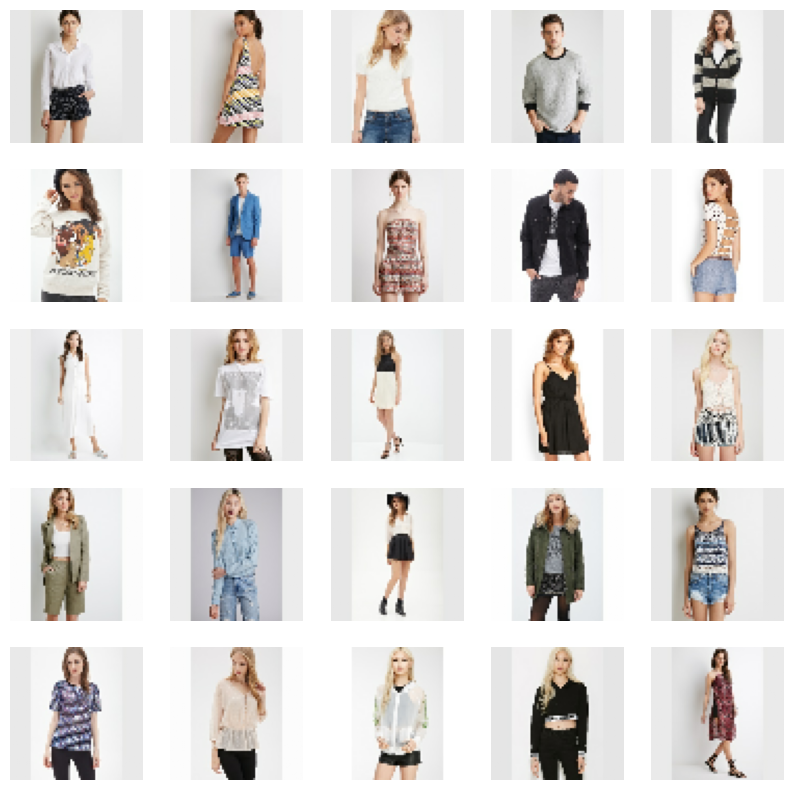

In [81]:
#################show the image####################
# Define a function to display a batch of images
def show_images(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    plt.show()
    
# Get a batch of images from the train_dataset
for images, color_ids, binary_attributes in train_dataset.take(1):
    show_images(images)

In [86]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

# Hyperparameters
embedding_dimension = 16
latent_dimension = 256
num_colors = 759
num_binary_attributes = 463
input_shape = (64, 64, 3)

# Cloth color embedding layer
color_embedding = layers.Embedding(num_colors, embedding_dimension, name="color_embedding")

# Encoder
# def create_encoder(input_shape, num_attributes):
#     inputs = Input(shape=input_shape, name="encoder_input")
#     attr_inputs = Input(shape=(num_attributes,), name="attribute_input")
    
#     x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation="relu")(inputs)
#     x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    
#     x = layers.Flatten()(x)
#     x = layers.Dense(latent_dimension, activation="relu")(x)
    
#     attr_x = layers.Dense(latent_dimension, activation="relu")(attr_inputs)
#     attr_x = layers.Dense(latent_dimension, activation="relu")(attr_x)
#     attr_x = layers.Dense(latent_dimension, activation="relu")(attr_x)
#     merged = layers.Concatenate()([x, attr_x])   
    
#     z_mean = layers.Dense(latent_dimension, name="z_mean")(merged)
#     z_log_var = layers.Dense(latent_dimension, name="z_log_var")(merged)
    
#     return Model([inputs, attr_inputs], [z_mean, z_log_var], name="encoder")

def create_vgg16_encoder(input_shape, num_attributes):
    inputs = Input(shape=input_shape, name="encoder_input")
    attr_inputs = Input(shape=(num_attributes,), name="attribute_input")
    
    # Use VGG16 as a feature extractor
    vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Set VGG16 layers to non-trainable
    for layer in vgg16.layers:
        layer.trainable = False
    
    # Apply VGG16 to the input images
    x = vgg16(inputs)
    
    # Flatten and reduce the dimensionality of the VGG16 features
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dimension, activation="relu")(x)
    
    attr_x = layers.Dense(latent_dimension, activation="relu")(attr_inputs)
    attr_x = layers.Dense(latent_dimension, activation="relu")(attr_x)
    
    merged = layers.Concatenate()([x, attr_x])
    
    z_mean = layers.Dense(latent_dimension, name="z_mean")(merged)
    z_log_var = layers.Dense(latent_dimension, name="z_log_var")(merged)
    
    return Model([inputs, attr_inputs], [z_mean, z_log_var], name="encoder")

def create_unet_decoder(latent_dimension, num_attributes):
    inputs = Input(shape=(latent_dimension + num_attributes,), name="decoder_input")

    x = layers.Dense(64 * 64 * 64, activation="relu")(inputs)
    x = layers.Reshape((64, 64, 64))(x)

    # Encoder part (contracting path)
    e1 = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    e2 = layers.Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu")(e1)

    # Decoder part (expanding path)
    d1 = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="relu")(e2)
    d1 = layers.Concatenate()([d1, e1])  # Skip connection
    d2 = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(d1)
    d2 = layers.Concatenate()([d2, x])  # Skip connection

    outputs = layers.Conv2DTranspose(3, kernel_size=3, padding="same", activation="sigmoid", name="decoder_output")(d2)

    return Model(inputs, outputs, name="decoder")

# # Decoder
# def create_decoder(latent_dimension, num_attributes):
#     inputs = Input(shape=(latent_dimension + num_attributes,), name="decoder_input")
    
#     x = layers.Dense(latent_dimension, activation="relu")(inputs)
#     x = layers.Dense(16 * 16 * 16, activation="relu")(x)
#     x = layers.Reshape((16, 16, 16))(x)
    
#     x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
#     x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    
#     outputs = layers.Conv2DTranspose(3, kernel_size=3, padding="same", activation="sigmoid", name="decoder_output")(x)
    
#     return Model(inputs, outputs, name="decoder")

# CVAE Model
class CVAE(Model):
    def __init__(self, encoder, decoder, color_embedding, num_binary_attributes, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.color_embedding = color_embedding
        self.num_binary_attributes = num_binary_attributes
    
    def call(self, inputs, training=False):
        images, color_ids, binary_attributes = inputs
        
        # Get color embeddings
        color_embeds = self.color_embedding(color_ids)
        
        # Concatenate color embeddings with binary attributes
        attribute_vector = layers.Concatenate(axis=-1)([color_embeds, binary_attributes])
        #attribute_vector = layers.Concatenate(axis=-1)([color_embeds])
        
        # Encode input images and attributes
        z_mean, z_log_var = self.encoder([images, attribute_vector])
        
        # Sample from the latent space
        batch_size = tf.shape(images)[0]
        epsilon = tf.random.normal(shape=(batch_size, latent_dimension))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        
        # Concatenate latent vector with the attribute vector
        z_cond = layers.Concatenate(axis=-1)([z, attribute_vector])
        
        # Decode the conditioned latent vector
        reconstructed_images = self.decoder(z_cond)
        
        return reconstructed_images, z_mean, z_log_var

# Instantiate the encoder, decoder, and CVAE model
#encoder = create_encoder(input_shape, embedding_dimension + num_binary_attributes)
# decoder = create_decoder(latent_dimension, embedding_dimension + num_binary_attributes)
# cvae = CVAE(encoder, decoder, color_embedding, num_binary_attributes)
vgg16_encoder = create_vgg16_encoder(input_shape, embedding_dimension + num_binary_attributes)
unet_decoder = create_unet_decoder(latent_dimension, embedding_dimension + num_binary_attributes)
cvae = CVAE(vgg16_encoder, unet_decoder, color_embedding, num_binary_attributes)
#cvae = CVAE(encoder, unet_decoder, color_embedding, num_binary_attributes)
# encoder = create_encoder(input_shape, embedding_dimension)
# decoder = create_decoder(latent_dimension, embedding_dimension)
# cvae = CVAE(encoder, decoder, color_embedding, num_binary_attributes)

# Loss function and optimizer
reconstruction_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Custom training step
@tf.function
def train_step(images, color_ids, binary_attributes):
    beta = 0.1
    with tf.GradientTape() as tape:
        reconstructed_images, z_mean, z_log_var = cvae([images, color_ids, binary_attributes], training=True)
        
        # Calculate reconstruction loss
        rec_loss = reconstruction_loss(layers.Flatten()(images), layers.Flatten()(reconstructed_images))
        rec_loss *= input_shape[0] * input_shape[1] * input_shape[2]
        
        # Calculate KL divergence loss
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        kl_loss = tf.reduce_mean(kl_loss)
        
        # Combine losses
        total_loss = rec_loss + beta * kl_loss
    
    # Calculate gradients and update model weights
    gradients = tape.gradient(total_loss, cvae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, cvae.trainable_variables))
    
    return total_loss, rec_loss, kl_loss

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    for batch_images, batch_color_ids, batch_binary_attributes in train_dataset:
        total_loss, rec_loss, kl_loss = train_step(batch_images, batch_color_ids, batch_binary_attributes)
        print(f"Total loss: {total_loss:.4f}, Reconstruction loss: {rec_loss:.4f}, KL loss: {kl_loss:.4f}")

Epoch 1/10
Total loss: 1944.2174, Reconstruction loss: 1940.0593, KL loss: 41.5804
Total loss: 1955.5485, Reconstruction loss: 1951.7070, KL loss: 38.4138
Total loss: 1878.0068, Reconstruction loss: 1874.1489, KL loss: 38.5795
Total loss: 1832.4989, Reconstruction loss: 1828.4689, KL loss: 40.3002
Total loss: 1820.6885, Reconstruction loss: 1816.4191, KL loss: 42.6936
Total loss: 1765.0116, Reconstruction loss: 1760.3962, KL loss: 46.1532
Total loss: 1741.3617, Reconstruction loss: 1736.3179, KL loss: 50.4380
Total loss: 1663.1763, Reconstruction loss: 1657.7605, KL loss: 54.1576
Total loss: 1593.6763, Reconstruction loss: 1587.7952, KL loss: 58.8113
Total loss: 1550.9468, Reconstruction loss: 1544.3894, KL loss: 65.5739
Total loss: 1483.5691, Reconstruction loss: 1476.3833, KL loss: 71.8574
Total loss: 1406.3593, Reconstruction loss: 1398.4448, KL loss: 79.1439
Total loss: 1296.8348, Reconstruction loss: 1287.8777, KL loss: 89.5718
Total loss: 1196.3226, Reconstruction loss: 1186.4779

Total loss: 441.5153, Reconstruction loss: 430.8583, KL loss: 106.5697
Total loss: 428.7070, Reconstruction loss: 418.2073, KL loss: 104.9968
Total loss: 450.2834, Reconstruction loss: 439.8227, KL loss: 104.6063
Total loss: 459.7787, Reconstruction loss: 449.1338, KL loss: 106.4494
Total loss: 427.8645, Reconstruction loss: 417.4665, KL loss: 103.9804
Total loss: 433.2767, Reconstruction loss: 422.8195, KL loss: 104.5723
Total loss: 443.6258, Reconstruction loss: 433.3589, KL loss: 102.6687
Total loss: 420.3904, Reconstruction loss: 410.6302, KL loss: 97.6020
Total loss: 408.7998, Reconstruction loss: 398.6820, KL loss: 101.1779
Total loss: 433.1195, Reconstruction loss: 423.2549, KL loss: 98.6461
Total loss: 462.8895, Reconstruction loss: 453.3263, KL loss: 95.6319
Total loss: 425.9237, Reconstruction loss: 416.4059, KL loss: 95.1779
Total loss: 467.1559, Reconstruction loss: 458.0738, KL loss: 90.8213
Epoch 3/10
Total loss: 395.8338, Reconstruction loss: 386.6686, KL loss: 91.6524
T

Total loss: 334.6688, Reconstruction loss: 327.2565, KL loss: 74.1233
Total loss: 346.5082, Reconstruction loss: 339.2061, KL loss: 73.0211
Total loss: 357.5422, Reconstruction loss: 350.0948, KL loss: 74.4742
Total loss: 337.9320, Reconstruction loss: 330.6046, KL loss: 73.2743
Total loss: 358.3586, Reconstruction loss: 350.8492, KL loss: 75.0946
Total loss: 338.2887, Reconstruction loss: 330.8070, KL loss: 74.8166
Total loss: 372.0465, Reconstruction loss: 364.4615, KL loss: 75.8500
Total loss: 357.5136, Reconstruction loss: 350.0540, KL loss: 74.5964
Total loss: 358.5463, Reconstruction loss: 351.0254, KL loss: 75.2092
Total loss: 351.8867, Reconstruction loss: 344.3819, KL loss: 75.0476
Total loss: 335.9801, Reconstruction loss: 328.3635, KL loss: 76.1662
Total loss: 344.8256, Reconstruction loss: 337.1868, KL loss: 76.3877
Total loss: 338.4057, Reconstruction loss: 330.8430, KL loss: 75.6264
Total loss: 357.0613, Reconstruction loss: 349.3709, KL loss: 76.9036
Total loss: 363.0570

Total loss: 325.9941, Reconstruction loss: 315.3690, KL loss: 106.2518
Total loss: 302.7385, Reconstruction loss: 292.1904, KL loss: 105.4810
Total loss: 312.3369, Reconstruction loss: 301.6330, KL loss: 107.0386
Total loss: 301.5222, Reconstruction loss: 291.0534, KL loss: 104.6880
Total loss: 335.4950, Reconstruction loss: 324.8441, KL loss: 106.5082
Total loss: 303.8784, Reconstruction loss: 293.3160, KL loss: 105.6245
Total loss: 308.3357, Reconstruction loss: 297.6532, KL loss: 106.8248
Total loss: 306.7326, Reconstruction loss: 296.1222, KL loss: 106.1035
Total loss: 294.9944, Reconstruction loss: 284.3094, KL loss: 106.8509
Total loss: 298.3295, Reconstruction loss: 287.8194, KL loss: 105.1005
Total loss: 313.2157, Reconstruction loss: 302.4815, KL loss: 107.3418
Total loss: 295.3773, Reconstruction loss: 284.5374, KL loss: 108.3996
Total loss: 303.5453, Reconstruction loss: 292.9204, KL loss: 106.2494
Total loss: 304.0251, Reconstruction loss: 293.2317, KL loss: 107.9340
Total 

Total loss: 273.4575, Reconstruction loss: 260.7333, KL loss: 127.2424
Total loss: 288.7250, Reconstruction loss: 275.9870, KL loss: 127.3803
Total loss: 274.2437, Reconstruction loss: 261.8038, KL loss: 124.3991
Total loss: 294.0110, Reconstruction loss: 281.3224, KL loss: 126.8862
Total loss: 287.3233, Reconstruction loss: 274.5397, KL loss: 127.8357
Total loss: 281.2985, Reconstruction loss: 268.8484, KL loss: 124.5015
Total loss: 266.8397, Reconstruction loss: 254.2175, KL loss: 126.2217
Total loss: 271.1904, Reconstruction loss: 258.4606, KL loss: 127.2980
Total loss: 277.4308, Reconstruction loss: 264.5522, KL loss: 128.7853
Total loss: 279.2793, Reconstruction loss: 266.4995, KL loss: 127.7981
Total loss: 293.8680, Reconstruction loss: 281.0495, KL loss: 128.1855
Total loss: 268.8435, Reconstruction loss: 256.0728, KL loss: 127.7071
Total loss: 293.7002, Reconstruction loss: 280.7327, KL loss: 129.6747
Total loss: 279.6781, Reconstruction loss: 266.9252, KL loss: 127.5287
Total 

Total loss: 264.2415, Reconstruction loss: 249.5399, KL loss: 147.0164
Total loss: 250.9189, Reconstruction loss: 236.3253, KL loss: 145.9356
Total loss: 253.8576, Reconstruction loss: 239.3897, KL loss: 144.6790
Total loss: 253.9658, Reconstruction loss: 239.3788, KL loss: 145.8701
Total loss: 259.2487, Reconstruction loss: 244.5753, KL loss: 146.7338
Total loss: 261.6167, Reconstruction loss: 247.0002, KL loss: 146.1654
Total loss: 264.8068, Reconstruction loss: 250.0081, KL loss: 147.9863
Total loss: 270.3236, Reconstruction loss: 255.5137, KL loss: 148.0990
Total loss: 260.1617, Reconstruction loss: 245.3578, KL loss: 148.0386
Total loss: 262.4924, Reconstruction loss: 247.8354, KL loss: 146.5695
Total loss: 253.5168, Reconstruction loss: 238.7088, KL loss: 148.0795
Total loss: 244.5684, Reconstruction loss: 229.6778, KL loss: 148.9059
Total loss: 250.4898, Reconstruction loss: 235.5386, KL loss: 149.5119
Total loss: 267.8911, Reconstruction loss: 252.9853, KL loss: 149.0583
Total 

In [87]:
# Evaluate the trained model on the test dataset
test_loss = []
for batch_images, batch_color_ids, batch_binary_attributes in test_dataset:
    reconstructed_images, z_mean, z_log_var = cvae([batch_images, batch_color_ids, batch_binary_attributes])
    rec_loss = reconstruction_loss(batch_images, reconstructed_images)
    rec_loss = tf.reduce_mean(rec_loss)
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    kl_loss = tf.reduce_mean(kl_loss)
    total_loss = rec_loss + kl_loss
    test_loss.append(total_loss)

test_loss = tf.reduce_mean(test_loss)
print(f"Test loss: {test_loss:.4f}")

Test loss: 157.8544


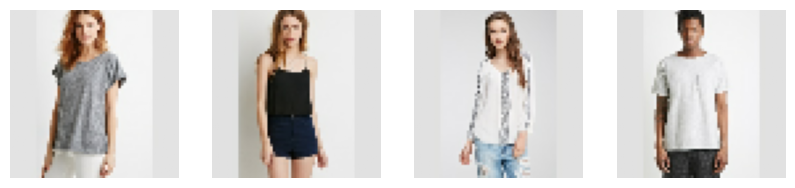

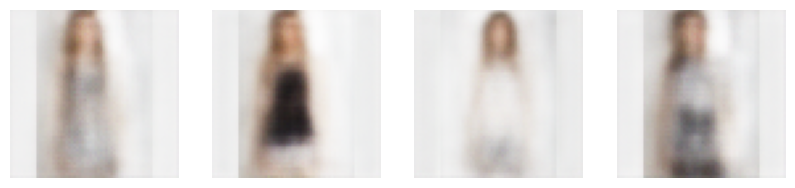

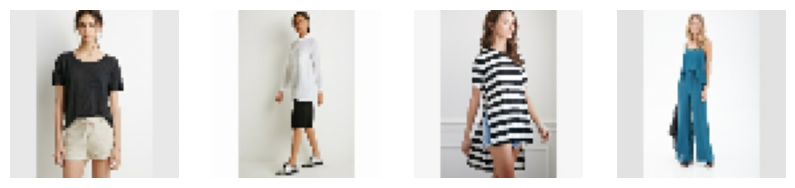

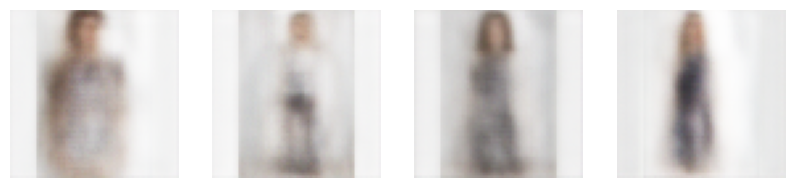

In [88]:
import matplotlib.pyplot as plt

def show(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(4):
        ax = plt.subplot(1,4,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    plt.show()

for batch_images, batch_color_ids, batch_binary_attributes in test_dataset.take(2):
    reconstructed_images, _, _ = cvae([batch_images, batch_color_ids, batch_binary_attributes])
    show(batch_images)
    show(reconstructed_images)